In [1]:
from art.utils import load_dataset
from art.classifiers import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from art.defences.trainer import AdversarialTrainer
from art.metrics import empirical_robustness

import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

# Loading hand writing dataset

In [2]:
def exract_two_classes( data, labels, classes=(0,1), no_instance=10000):
    data_zeroes = data[ np.argwhere( labels ==  classes[0] ).reshape( -1 ) ][ :no_instance ]
    data_ones = data[ np.argwhere( labels == classes[1] ).reshape( -1 ) ][ :no_instance ]
    x = np.vstack( (data_zeroes, data_ones) )
    
    # normalize the data
    x = x / 255.

    labels_zeroes = np.zeros( data_zeroes.shape[ 0 ] )
    labels_ones = np.ones( data_ones.shape[ 0 ] )
    y = np.append( labels_zeroes, labels_ones )

    return x, y

In [3]:
cifar10 = tf.keras.datasets.cifar10# Object of the MNIST dataset
(x_train, y_train),(x_test, y_test) = cifar10.load_data() # Load data


# extract ones and zeroes
x_train, y_train = exract_two_classes( x_train, y_train )
x_test, y_test = exract_two_classes( x_test, y_test )

In [4]:
x_train = np.array(x_train).astype("float")
y_train = np.array(y_train).astype("float")
x_test = np.array(x_test).astype("float")
y_test = np.array(y_test).astype("float")

In [5]:
print("Lengh of dimensions for x_train: ", x_train.shape)
print("Lengh of dimensions for y_train: ", y_train.shape)
print("Lengh of dimensions for x_test: ", x_test.shape)
print("Lengh of dimensions for y_test: ", y_test.shape)

Lengh of dimensions for x_train:  (20000, 32, 32, 3)
Lengh of dimensions for y_train:  (20000,)
Lengh of dimensions for x_test:  (4000, 32, 32, 3)
Lengh of dimensions for y_test:  (4000,)


In [6]:
'''reshape'''
x_train = x_train.reshape(-1,32,32,3)
x_test = x_test.reshape(-1,32,32,3)

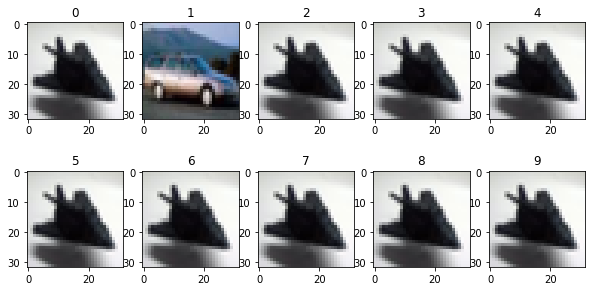

In [7]:
n_classes = 10
inds=np.array([y_train==i for i in range(n_classes)])
f,ax=plt.subplots(2,5,figsize=(10,5))
ax=ax.flatten()
for i in range(n_classes):
    ax[i].imshow(x_train[np.argmax(inds[i])])
    ax[i].set_title(str(i))
plt.show()

# Simple fully-connected neural network with 2 hidden layers

In [8]:
np.random.seed(44)
model = tf.keras.Sequential([
    # 1st convolution
    tf.keras.layers.Conv2D(filters=20, kernel_size=(3,3), activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'),
    # 2nd convolution
    tf.keras.layers.Conv2D(filters=20, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'),
    # dense
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax') 
])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_object,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 20)        560       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 20)        3620      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 720)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               360500    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5

In [9]:
'''Traning the model'''
history = model.fit(x_train, y_train, epochs=5, verbose=1,
                    validation_data=(x_test, y_test))

#(train_x, train_y, epochs=5,validation_data=(valid_x, valid_y))

Epoch 1/5
625/625 [==============================] - 23s 36ms/step - loss: 0.6336 - accuracy: 0.6321 - val_loss: 0.4836 - val_accuracy: 0.6957
Epoch 2/5
625/625 [==============================] - 20s 33ms/step - loss: 0.4905 - accuracy: 0.6973 - val_loss: 0.4894 - val_accuracy: 0.7070
Epoch 3/5
625/625 [==============================] - 19s 30ms/step - loss: 0.4571 - accuracy: 0.7091 - val_loss: 0.6077 - val_accuracy: 0.7143
Epoch 4/5
625/625 [==============================] - 21s 33ms/step - loss: 0.4319 - accuracy: 0.7181 - val_loss: 0.8255 - val_accuracy: 0.7168
Epoch 5/5
625/625 [==============================] - 21s 34ms/step - loss: 0.4174 - accuracy: 0.7260 - val_loss: 0.9372 - val_accuracy: 0.7128


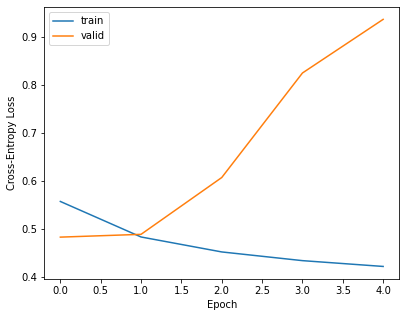

In [10]:
'''Plot loss trajectory throughout training'''
plt.figure(1, figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

Test cross-entropy loss: 0.93722
Test accuracy: 0.71275


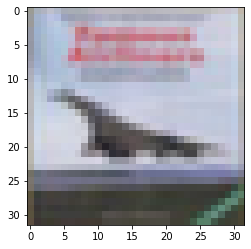

In [11]:
'''Score on original data'''
score = model.evaluate(x_test, y_test, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.5f' % score[1])
plt.figure()
plt.imshow(x_test[0])  
plt.show()

# FGSM attack 

In [12]:
'''wrap the model an calculte emperical robustnees'''
classifier = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(32,32,3),
                                   loss_object = loss_object, clip_values=(0, 1))
print('robustness of the undefended model', 
      empirical_robustness(classifier, x_test, 'fgsm', {}))

robustness of the undefended model 0.10543219392735938


In [13]:
eps_list=np.arange(0.01, 0.055, 0.005)
acc=np.zeros(eps_list.size)
for i in range(eps_list.size):
    '''
    creat adversial examples using build in FastGradientMethod from ART
    also predict based on the current  adversial examples
    '''

    adv_fgsm_model = FastGradientMethod(classifier, norm=1, eps=eps_list[i]*32*32, targeted=False)
    adv_fgsm_x = adv_fgsm_model.generate(x=x_test)
    prediction_x = classifier.predict(x=adv_fgsm_x)
    acc[i]=classifier._model.evaluate(adv_fgsm_x, y_test)[1]
    print(eps_list[i])

125/125 [==============================] - 1s 9ms/step - loss: 0.5377 - accuracy: 0.6660
0.01
125/125 [==============================] - 1s 11ms/step - loss: 0.6322 - accuracy: 0.6288
0.015
125/125 [==============================] - 1s 11ms/step - loss: 0.8691 - accuracy: 0.5888
0.019999999999999997
125/125 [==============================] - 1s 10ms/step - loss: 1.1649 - accuracy: 0.5465
0.024999999999999998
125/125 [==============================] - 1s 9ms/step - loss: 1.4771 - accuracy: 0.5125
0.03
125/125 [==============================] - 1s 10ms/step - loss: 1.7786 - accuracy: 0.4815
0.034999999999999996
125/125 [==============================] - 1s 9ms/step - loss: 2.0656 - accuracy: 0.4575
0.039999999999999994
125/125 [==============================] - 1s 11ms/step - loss: 2.3406 - accuracy: 0.4360
0.045
125/125 [==============================] - 1s 10ms/step - loss: 2.6054 - accuracy: 0.4193
0.049999999999999996


In [14]:
eps_list=np.arange(0.01, 0.055, 0.005)
acc=np.zeros(eps_list.size)
for i in range(eps_list.size):
    '''
    creat adversial examples using build in FastGradientMethod from ART
    also predict based on the current  adversial examples
    '''

    adv_fgsm_model = FastGradientMethod(classifier, norm=2, eps=eps_list[i]*32*32, targeted=False)
    adv_fgsm_x = adv_fgsm_model.generate(x=x_test)
    prediction_x = classifier.predict(x=adv_fgsm_x)
    acc[i]=classifier._model.evaluate(adv_fgsm_x, y_test)[1]
    print(eps_list[i])

125/125 [==============================] - 1s 10ms/step - loss: 7.8284 - accuracy: 0.3020
0.01
125/125 [==============================] - 1s 9ms/step - loss: 8.4480 - accuracy: 0.3055
0.015
125/125 [==============================] - 1s 10ms/step - loss: 8.7251 - accuracy: 0.3162
0.019999999999999997
125/125 [==============================] - 1s 10ms/step - loss: 8.7840 - accuracy: 0.3237
0.024999999999999998
125/125 [==============================] - 2s 12ms/step - loss: 8.7476 - accuracy: 0.3338
0.03
125/125 [==============================] - 1s 11ms/step - loss: 8.7589 - accuracy: 0.3430
0.034999999999999996
125/125 [==============================] - 1s 9ms/step - loss: 8.7530 - accuracy: 0.3507
0.039999999999999994
125/125 [==============================] - 1s 10ms/step - loss: 8.7763 - accuracy: 0.3568
0.045
125/125 [==============================] - 1s 10ms/step - loss: 8.7687 - accuracy: 0.3632
0.049999999999999996


In [15]:
eps_list=np.arange(0.01, 0.055, 0.005)
acc=np.zeros(eps_list.size)
for i in range(eps_list.size):
    '''
    creat adversial examples using build in FastGradientMethod from ART
    also predict based on the current  adversial examples
    '''

    adv_fgsm_model = FastGradientMethod(classifier, norm=np.inf, eps=eps_list[i], targeted=False)
    adv_fgsm_x = adv_fgsm_model.generate(x=x_test)
    prediction_x = classifier.predict(x=adv_fgsm_x)
    acc[i]=classifier._model.evaluate(adv_fgsm_x, y_test)[1]
    print(eps_list[i])

125/125 [==============================] - 2s 12ms/step - loss: 0.5560 - accuracy: 0.6503
0.01
125/125 [==============================] - 1s 10ms/step - loss: 0.7704 - accuracy: 0.6033
0.015
125/125 [==============================] - 1s 8ms/step - loss: 1.1028 - accuracy: 0.5537
0.019999999999999997
125/125 [==============================] - 1s 8ms/step - loss: 1.4590 - accuracy: 0.5160
0.024999999999999998
125/125 [==============================] - 1s 8ms/step - loss: 1.8000 - accuracy: 0.4795
0.03
125/125 [==============================] - 1s 9ms/step - loss: 2.1242 - accuracy: 0.4557
0.034999999999999996
125/125 [==============================] - 1s 9ms/step - loss: 2.4333 - accuracy: 0.4308
0.039999999999999994
125/125 [==============================] - 1s 8ms/step - loss: 2.7166 - accuracy: 0.4128
0.045
125/125 [==============================] - 1s 8ms/step - loss: 2.9735 - accuracy: 0.3972
0.049999999999999996


# ----------------------------------------------------

In [16]:
# print('class prediction for the adversarial sample:',classifier.predict(adv_fgsm_x))
print('accuracy on adversarial examples:' )
print(classifier._model.evaluate(adv_fgsm_x, y_test)[1])

accuracy on adversarial examples:
125/125 [==============================] - 1s 8ms/step - loss: 2.9735 - accuracy: 0.3972
0.3972499966621399


Test cross-entropy loss: 2.97348
Test accuracy: 0.39725


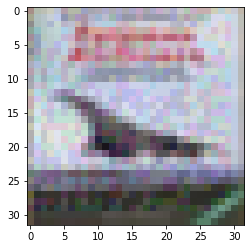

In [17]:
'''Score on adversarial examples'''
score = model.evaluate(adv_fgsm_x, y_test, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.5f' % score[1])
plt.figure()
plt.imshow(adv_fgsm_x[0])  
plt.show()